# Библиотеки для работы с CV

## Предобработка изображений с помощью cv2 и Pillow

Две самые популярные библиотеки для работы с приложениями — это `cv2` и `Pillow`.

- cv2. Производительная библиотека, написанная на C++, которая позволяет осуществлять множество операций над изображениями и видео. Она содержит много методов для их обработки, которые были популярны до появления нейросетей, то есть в эпоху так называемого классического Computer Vision.

- Pillow. Более молодая библиотека, написанная на языке C. Её основной фокус направлен на предобработку изображений и простоту.

In [2]:
import requests

import cv2
from PIL import Image
import numpy as np

from ml_dl_experiments import settings

url = "https://raw.githubusercontent.com/jigsawpieces/dog-api-images/main/eskimo/n02109961_10021.jpg"
response = requests.get(url, stream=True)

image_path: str = settings.SOURCE_PATH + "ml_dl/CNN/eskimo_dog.jpg"

with open(image_path, "wb") as f:
    f.write(response.content)

img_pil = Image.open(image_path)
img_cv2 = cv2.imread(image_path)

В отличие от Pillow, cv2 использует другой порядок каналов при загрузке — BGR, а не RGB. Поэтому при чтении необходимо приводить изображение в стандартный формат с помощью перестановки каналов cv2.COLOR_BGR2RGB в методе cv2.cvtColor

In [ ]:
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB) # type:ignore BGR -> RGB 

In [5]:
# не выведет ничего при ~равенстве массивов, иначе - ошибка
np.testing.assert_allclose(img_cv2, img_pil, atol=1e-8)

Выполним масштабирование

In [8]:
shape = (224, 224)
img_pil = img_pil.resize(shape)
img_cv2 = cv2.resize(img_cv2, shape)

np.testing.assert_allclose(img_cv2, img_pil, atol=1e-8) 

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=1e-08

Mismatched elements: 94421 / 150528 (62.7%)
Max absolute difference among violations: 56
Max relative difference among violations: 3.
 ACTUAL: array([[[ 91, 116,  58],
        [ 88, 113,  56],
        [ 89, 114,  57],...
 DESIRED: array([[[ 90, 115,  58],
        [ 88, 113,  56],
        [ 89, 114,  57],...

Здесь уже видны различия — из-за разных алгоритмов масштабирования и их реализации мы не всегда можем получить одинаковые результаты, вызывая в общем схожие методы. Расхождения обычно небольшие, так что явных артефактов на изображении не будет. Но лучше всё-таки помнить про это, фиксировать один алгоритм ремасштабирования и в дальнейшем придерживаться его.

Нормализация:

In [9]:
img_pil = np.array(img_pil) / 255
img_cv2 = img_cv2 / 255

print(np.min(img_cv2), np.min(img_pil), np.max(img_cv2), np.max(img_pil)) 

0.0 0.0 0.9490196078431372 0.9529411764705882


In [13]:
img_pil.shape

(224, 224, 3)

Для изображения с shape=(224, 224, 3) в формате RGB, чтобы вычислить среднее и стандартное отклонение для каждого канала с помощью numpy, используем следующие подходы:

## Расчёт mean и std для каналов

```python
import numpy as np

# Пусть img — numpy-массив изображения с shape=(224, 224, 3)
mean = np.mean(img, axis=(0, 1))  # Среднее для каждого канала
std = np.std(img, axis=(0, 1))    # Стандартное отклонение для каждого канала
```

## Детали

- Аргумент axis=(0, 1) означает, что функция считается по высоте и ширине, отдельно для каждого канала (последнее измерение — RGB).
- В результате mean и std будут массивами из 3 элементов: [mean_R, mean_G, mean_B] и [std_R, std_G, std_B].

## Пример вывода

```python
print("Mean (R, G, B):", mean)
print("Std  (R, G, B):", std)
```

Для типичных задач машинного обучения mean и std используют для нормализации входных данных изображения.

При загрузке порядок размерностей H × W × C различается от того, какой требует PyTorch при использовании моделей — C × H × W.
Чтобы преобразовать изображения к формату Channels × Heigth × Width, можно воспользоваться стандартной перестановкой каналов из NumPy: методом transpose. Он применяется к массивам и принимает на вход индексы каналов в нужном нам порядке. 

In [20]:
print(f"Размеры до: {img_cv2.shape}")

img_cv2 = img_cv2.transpose(2, 0, 1)
print(f"Размеры после: {img_cv2.shape}")

Размеры до: (356, 356, 3)
Размеры после: (3, 356, 356)


Библиотека cv2 может быть предпочтительна в ситуациях, когда нужна более быстрая обработка.
cv2, написанная на C++, быстрее, чем Pillow.

In [18]:
# читаем картинку
img_cv2 = cv2.imread(image_path)
# переводим в RGB цвета
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
# Масшатбируем
shape = (356, 356)
img_cv2 = cv2.resize(img_cv2, shape)
# Приводим к диапазону 0-1
img_cv2 = img_cv2 / 255
# Поканальная нормализация
# mean = np.mean(img_cv2, axis=(0, 1))
# std = np.std(img_cv2, axis=(0, 1))

mean = np.array([0.4, 0.42, 0.44])
std =np.array([0.2, 0.21, 0.22])

img_cv2 = (img_cv2 - mean) / std 

print(img_cv2[0,0,1].round(3))
mean, std

0.166


(array([0.4 , 0.42, 0.44]), array([0.2 , 0.21, 0.22]))

Чаще всего представленные библиотеки для задач DL используются как загрузчики данных — выбор конкретного фреймворка в таком сценарии использования не так критичен. 

Но когда вы хотите выполнять обработку видео, применять какие-то методы из классического компьютерного зрения и при этом иметь большую скорость обработки, стоит отдать предпочтение cv2.

## Библиотека  timm


Библиотека timm — Torch IMage Models, входящая в экосистему платформы huggingface. timm значительно упрощает загрузку, использование и настройку моделей под конкретные задачи CV.

In [1]:
import timm

total_models = len(timm.list_models())
print(f"Общее число моделей: {total_models}")
print(f"Первые 5 моделей семейства resnet: \n{timm.list_models(filter='resnet*')[:5]}")

Общее число моделей: 1279
Первые 5 моделей семейства resnet: 
['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26']


Нобходимую модель нужно скачать и проинициализировать. Делается это с помощью метода `create_model(model_name=..)`:

In [3]:
model = timm.create_model(model_name="resnet18")
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

По умолчанию модели инициализируются случайными весами. Чтобы использовать предобученный вариант, укажем pretrained=True, а также визуализируем конфигурационный файл с помощью атрибута модели pretrained_cfg 

In [4]:
model = timm.create_model(
    model_name="resnet18",
    pretrained=True
)

model.pretrained_cfg

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth',
 'hf_hub_id': 'timm/resnet18.a1_in1k',
 'architecture': 'resnet18',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'license': 'apache-2.0',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

Основные параметры, которые могут быть полезны:

- `tag` — как правило, содержит информацию об обучении модели. В частности, здесь a1_in1k — означает, что модель обучалась на датасете ImageNet с 1000 классами.
    
- `input_size` — размер изображений, использованный при тренировке.
    
- `fixed_input_size` — атрибут, указывающий на жёсткость ограничения входного размера изображений. В данном случае False означает, что ограничений нет.
    
- `mean и std` — коэффициенты для нормализации изображений, использованные при тренировке.

Для загрузки pretrained модели с помощью timm из локального файла нужно сделать следующее:

## Загрузка модели timm с локальной pretrained весовой:

1. Создайте модель с `pretrained=False`, чтобы не загружать веса из интернета.
2. Загрузите веса из локального файла (обычно `.pth` или `.bin`) с помощью `torch.load`.
3. Подгрузите веса в модель через `model.load_state_dict`.
4. Модель готова к использованию.

## Пример кода:

```python
import timm
import torch

# Создаем модель без загрузки pretrained весов из интернета
model = timm.create_model('имя_модели', pretrained=False)

# Путь к файлу с весами на локальном диске
weights_path = 'путь/до/файла/model_weights.pth'

# Загружаем веса
state_dict = torch.load(weights_path, map_location='cpu')

# Если в state_dict есть ключ 'model' или 'state_dict', нужно извлечь
# Пример для common case:
if 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']

# Загружаем веса в модель
model.load_state_dict(state_dict)

# Модель готова для использования
model.eval()
```

### Особенности
- Убедитесь, что название модели в create_model совпадает с той, для которой предназначены веса.
- Если файл весов был сохранен с использованием `DataParallel` (с префиксом 'module.' в ключах), возможно потребуется подправить ключи перед загрузкой.

Так вы можете передать путь к файлу с pretrained весами и загрузить их локально без подключения к интернету.

Оценим инференс одной модели. maxvit_large_tf_384
1. Загрузим картинку и модель
2. Масштабируем в нужный формат
3. Нормализуем в диапазон от 0 до 1, затем в формат, необходимый для тренировки конкретной модели
4. Вывести результирующую размерность изображения

In [10]:
import timm
import torch.nn as nn
import cv2
import numpy as np

from ml_dl_experiments import settings
# Загрузим изображение
image_path: str = settings.SOURCE_PATH + "ml_dl/CNN/eskimo_dog.jpg"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255

In [ ]:
# Загрузим модель, выведем конфиги

model = timm.create_model(
    model_name="maxvit_large_tf_384",
    pretrained=True
)

model.pretrained_cfg


model.safetensors:   0%|          | 0.00/849M [00:00<?, ?B/s]

{'url': '',
 'hf_hub_id': 'timm/maxvit_large_tf_384.in1k',
 'architecture': 'maxvit_large_tf_384',
 'tag': 'in1k',
 'custom_load': False,
 'input_size': (3, 384, 384),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'squash',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': (12, 12),
 'first_conv': 'stem.conv1',
 'classifier': 'head.fc',
 'license': 'apache-2.0'}

In [5]:
mean, std = np.array(model.pretrained_cfg['mean']), np.array(model.pretrained_cfg['std'])
shape = (384, 384)

In [11]:
# Изменим масштаб и нормализуем под модель
img = cv2.resize(img, shape)

img = (img - mean) / std
img.shape

(384, 384, 3)

In [19]:
import torch
from torchvision.transforms import ToTensor
tensor = ToTensor()
image_tensor = tensor(img)
image_tensor = image_tensor.to(torch.float32)
model.eval()
with torch.no_grad():
    out = model(image_tensor.unsqueeze(0))

result = out.softmax(dim=1)
top5_probabilities, top5_class_indices = torch.topk(result * 100, k=5)
top5_probabilities, top5_class_indices

(tensor([[65.1152, 23.5729,  0.7286,  0.1099,  0.1031]]),
 tensor([[250, 248, 249, 174, 270]]))

Модель на 65% уверена, что это сибирская хаски.

Ещё одна важная часть возможностей библиотеки связана с инициализацией самой модели.

Большая часть моделей обучались на задачу классификации и построены по упрощённому принципу:

- последовательные слои конволюций,
    
- агрегирование значений карт признаков,

- линейный классификатор.

Для конечной задачи не всегда интересен результирующий классификатор — больше наиболее важны признаки модели (тензора до линейного слоя). 

Производить `feature-extraction` в `timm` легко — достаточно указать `features_only=True`. 

```py
model = timm.create_model("efficientnet_b0",
                          pretrained=True,
                          features_only=True)

x = torch.randn(1, 3, 224, 224)
out = model(x)
print([x.shape for x in out])
```

```py
[torch.Size([1, 16, 112, 112]), 
 torch.Size([1, 24, 56, 56]), 
 torch.Size([1, 40, 28, 28]), 
 torch.Size([1, 112, 14, 14]), 
 torch.Size([1, 320, 7, 7])]
```

Получаем разноуровневые признаки из модели — какие-то будут акцентироваться на крупных деталях, какие-то на мелких. Часто использование признаков разных уровней помогает в решении задачи или улучшении качества существующей.

Например, это эффективно в задаче детекции, когда мы хотим обнаруживать как локальные паттерны (ранние слои: цвета и градиенты), так и глобальные (части объектов: глаза, руки и т. д.). 

Под «уровнем» здесь подразумевается один из последовательных блоков. В частности, в `efficientnet_b0` это индекс группы `InvertedResidual` - блоков — таких в этой модели 5 штук.

Количеством извлекаемых признаков можно управлять с помощью параметра `out_indices`, в который передаётся список индексов, соответствующий блокам признаков. 

Для некоторых задач могут быть релевантны только признаки с самых глубоких слоёв — и для модели из примера выше мы могли бы извлечь, например, только 2 последних признака. 

Чтобы понять общее количество возвращаемых признаков для конкретной модели, можно сначала указать только `features_only`, а по количеству тензоров понять, какие индексы можно указывать.

```py
model = timm.create_model("efficientnet_b0",
                          pretrained=True,
                          features_only=True,
                          out_indices=[3, 4])

x = torch.randn(1, 3, 224, 224)
out = model(x)
print([x.shape for x in out])

[torch.Size([1, 112, 14, 14]), 
 torch.Size([1, 320, 7, 7])]
```

Без библиотеки timm нам пришлось бы вручную реализовывать поддержку каждой архитектуры на PyTorch, а timm берёт эту работу на себя и обеспечивает единый интерфейс для любых моделей.

# Аугментация данных и работа с несбалансированным датасетом
## Виды и особенности применения аугментаций

Аугментации изображений можно условно разделить на несколько категорий:

- Геометрические преобразования — например, поворот и отражение. Они позволяют добавить в выборку разные вращения объектов.
  
- Цветовые коррекции — например, яркость и контраст. Они имитируют всевозможные цветовые вариации одного и того же объекта
    
- Dropout — например, вырезание небольших кусков изображения. Он несёт в себе такую же логику, как и одноимённый параметр в нейросетях, — вырезая часть изображения, мы как бы проводим регуляризацию, стабилизируя процесс обучения модели.

- Добавление шумов — например, размытие и гауссовский шум. Они добавляют артефакты съёмки или качества изображения
    
- Доменно-специфичные аугментации — например, аппаратные искажения в медицинских снимках и засветы кадров. Это модификации исходного изображения, которые характерны для изображений из определённых областей, — например, эффект тумана для фотографии машин на трассе.

Получается, что при применении аугментаций всегда нужно отталкиваться от конкретной задачи. Где-то можно применить полный набор, а где-то — только лёгкий шум.

## Аугментация на примерах

Для аугментаций будем использовать библиотеку `albumentations`.

По аналогии с `torchvision`, все аугментации объединяются методом Compose, каждая из аугментаций в котором обладает параметром вероятности применения, p=[0, 1.0]. Поскольку все аугментации выбираются случайно, для воспроизводимости или дебаггинга можно указать параметр `seed` в `Compose` или же использовать задание глобальной переменной `PYTHONHASHSEED`.

Чтобы применить аугментации к изображению, нужно проинициализировать их и передать на вход изображение. В результате получится словарь, в котором трансформированное изображение можно найти по ключу `image`. 

Так сделано потому, что помимо самих изображений некоторые аугментации можно применять к разметке изображений. Например, квадрат, выделяющий на картинке котика, можно растянуть или сжать, как и само изображение.

```py
import albumentations as A

transform = A.Compose([
    # аугментации здесь
], seed=42)

# обращаемся по ключу
transform(image= <загруженное_изображение>)["image"]
```

In [3]:
import albumentations as A
from PIL import Image
import requests

from ml_dl_experiments import plot_image, settings

SIZE = 224
image_path: str = settings.SOURCE_PATH + "ml_dl/CNN/corgi.jpg"
# загружаем и сохраняем картинку
url = "https://raw.githubusercontent.com/jigsawpieces/dog-api-images/main/corgi/14917192_10154550690893449_81787730512372227_o.jpg"
response = requests.get(url, stream=True)

with open(image_path, "wb") as f:
    f.write(response.content)

img = Image.open(image_path)

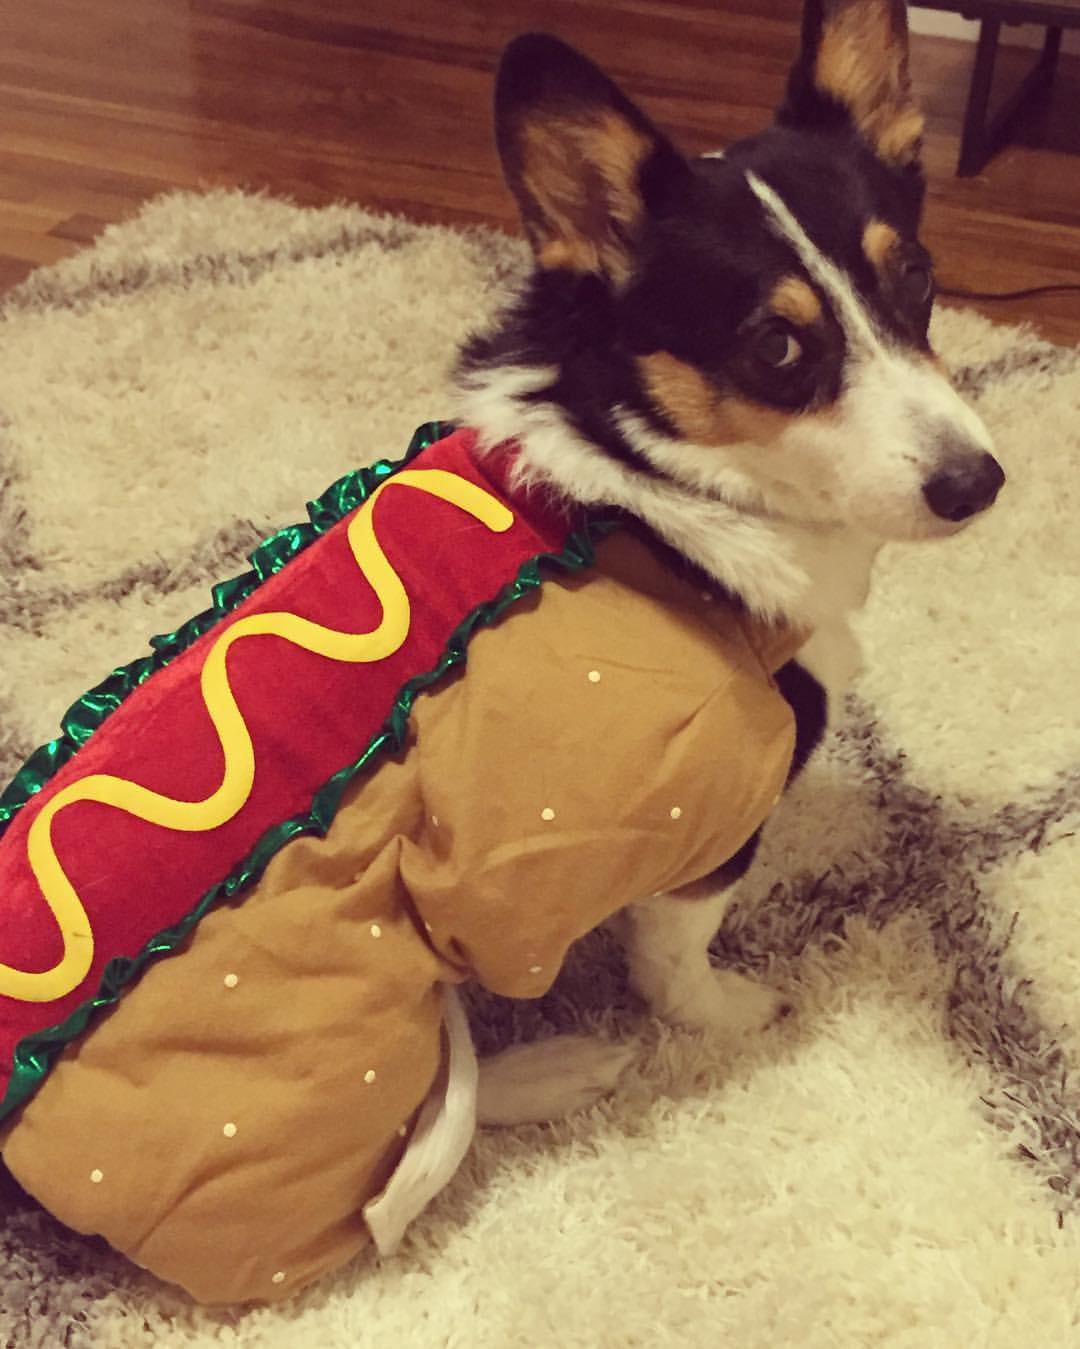

In [4]:
img

## 1. Масштабирование и обрезка
Здесь есть такие варианты:

- Resize — базовое масштабирование.
  
- SmallestMaxSize, LongestMaxSize — масштабируют изображения так, что наименьшая или наибольшая сторона приводится к задаваемому значению.
    
- RandomCrop — выделение случайного прямоугольника на изображении с обрезкой всего, не попавшего в периметр. `Применяется после масштабирования.`
    
- RandomResizedCrop — то же, что RandomCrop, но уже объединённое с масштабированием.

In [7]:
import numpy as np

img = np.array(img)

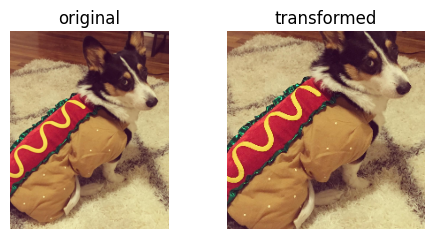

In [8]:

transforms = A.Compose([
    A.SmallestMaxSize(max_size=SIZE, p=1.0),
    A.RandomCrop(height=SIZE, width=SIZE, p=1.0)
    ],
    seed=42,
)

plot_image(img, transforms(image=img)["image"])

2. Геометрические

- HorizontalFlip — отражение по горизонтали.
  
- SquareSymmetry — поворот на 0-270 градусов с шагом 90 градусов.

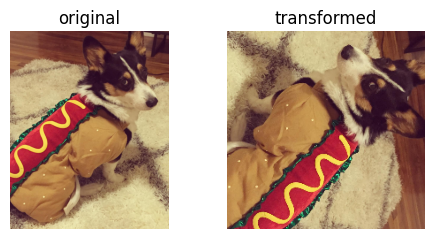

In [9]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1) # не принимает других аргументов на вход
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"])

## 3. Перспектива и аффинные преобразования

- Perspective — приближение объекта.

- Affine — изменяют объект так, что все параллельные линии на изображении остаются параллельными после трансформации.

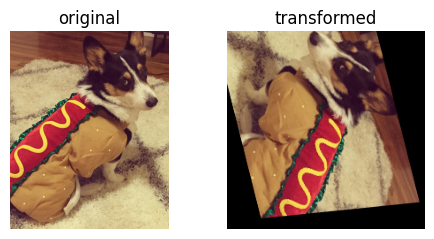

In [10]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(
                scale=(0.8, 1.2), rotate=(-15, 15), fill=0,
                translate_percent=(-0.1, 0.1), shear=(-10, 10), p=1
            ),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"]) 

Аргументы задаются диапазоном значений (min, max):

- scale — кратность отдаления или приближения объекта соответственно.

- rotate — поворот в градусах.
    
- translate_percent — смещение всего изображения вдоль одной из осей, в примере выше мы допускаем смещение на 1/10 часть изображения.
    
- shear — трапециевидный сдвиг, угол смещения, который превращает прямоугольное изображение в трапецию. В примере от –10° до +10°.
    
- fill — целое число, цветовое значение пикселя для заполнения образовавшейся пустоты, используется по аналогии и в других аугментациях. 0 — чёрный, 255 — белый цвет.

4. Dropout

- CoarseDropout — удаление случайных прямоугольных областей.
    
- GridDropout — удаление случайных прямоугольных областей, расположенных по равномерной сетке.

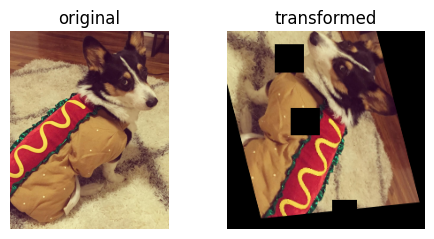

In [11]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
    ],
    seed=4,
)


plot_image(img, transforms(image=img)["image"])

Аргументы (min, max):

- num_holes_range — число удаляемых областей, задаётся диапазоном.
    
- hole_height_range, hole_width_range — высота и ширина удаляемых областей, в примере выше задан как доля от размера картинки.

## 5. Изменяющие цветовые каналы

- ToGray — перевод в чёрно-белое изображение.
  
- ChannelDropout — удаление цветового канала (из RGB) и заполнение фиксированным оттенком (fill).

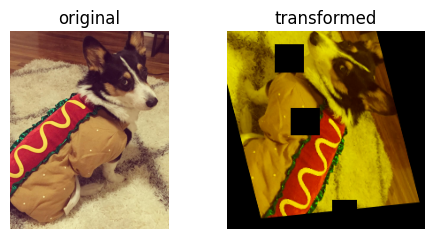

In [12]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
        A.ChannelDropout(channel_drop_range=(1, 1), fill=0, p=0.3),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"]) 

channel_drop_range — число случайно удаляемых каналов от 1 до 2 максимум. 

fill и p несут тот же смысл, что и в прошлых аугментациях.

## 6. Изменения цвета

- RandomBrightnessContrast — изменения яркости и контрастности.
  
- HueSaturationValue — изменение насыщенности и оттенков цветов.
  
- ColorJitter — одновременное изменение яркости, контрастности, насыщенности и оттенков цветов.

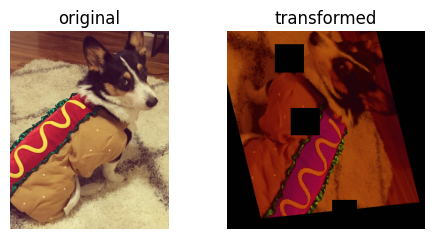

In [13]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
        A.ChannelDropout(channel_drop_range=(1, 1), fill=0, p=0.3),
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"]) 

Аргументы принимают либо диапазон изменения значений (0.8, 1.2), либо дробное число (0.2 эквивалентно (0.8, 1.2); 0 = без изменений):

- brightness — яркость,
  
- contrast — контраст,
  
- saturation — насыщенность,
  
- hue — оттенок.

## 7. Размытия
Позволяют убрать шумы на изображении.

- GaussianBlur — размытие с гауссовым фильтром.
    
- MotionBlur  — имитация размытия от движения.

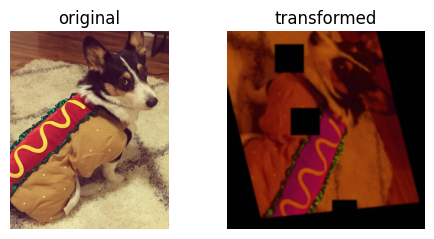

In [14]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
        A.ChannelDropout(channel_drop_range=(1, 1), fill=0, p=0.3),
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
        A.GaussianBlur(blur_limit=(3, 10), p=0.5),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"]) 

blur_limit — размер применяемого фильтра в пикселях. Больше — сильнее размытие.

## 8. Шумы
Случайные изменения значений пикселей.

- GaussNoise — добавление шума из нормального распределения.
    
- ISONoise — изменения оттенков.
    
- SaltAndPepper — случайно заменяет значения пикселей на максимальное (Salt, или белые пиксели) или минимальное (Pepper, или черные пиксели) значение, вычисленные по самому изображению.

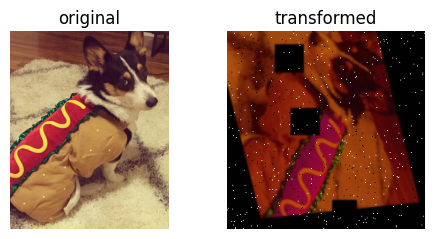

In [15]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
        A.ChannelDropout(channel_drop_range=(1, 1), fill=0, p=0.3),
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
        A.GaussianBlur(blur_limit=(3, 10), p=0.5),
        A.SaltAndPepper(amount=(0.01, 0.06), p=0.5),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"]) 

amount — диапазон доли случайно изменяемых пикселей.

## 9. Артефактные
Ухудшают качество изображения.

- ImageCompression — применяют алгоритмы сжатия jpeg и webp для ухудшения качества.
    
- Downscale — уменьшает, а затем восстанавливает разрешение изображения до исходного размера. За счёт этого качество теряется.

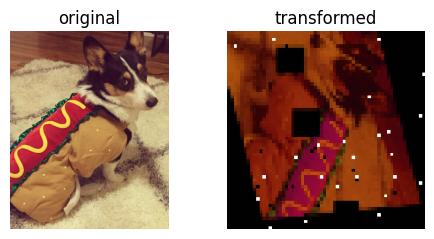

In [16]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=SIZE, p=1.0),
        A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
        A.SquareSymmetry(p=1),
        A.Affine(scale=(0.8, 1.2),
                 rotate=(-15, 15),
                 translate_percent=(-0.1, 0.1),
                 shear=(-10, 10),
                 fill=0,
                 p=1),
        A.CoarseDropout(num_holes_range=(2, 8),
                        hole_height_range=(int(0.07 * SIZE), int(0.15 * SIZE)),
                        hole_width_range=(int(0.1 * SIZE), int(0.15 * SIZE)),
                        fill=0,
                        p=1.0),
        A.ChannelDropout(channel_drop_range=(1, 1), fill=0, p=0.3),
        A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
        A.GaussianBlur(blur_limit=(3, 10), p=0.5),
        A.SaltAndPepper(amount=(0.01, 0.06), p=0.5),
        A.Downscale(scale_range=(0.25, 0.5), p=0.5),
    ],
    seed=4,
)

plot_image(img, transforms(image=img)["image"])

- scale_range — относительный диапазон для применения сжатия.

Кстати, на картинке можно заметить, как шум от SaltAndPepper тоже исказился. 

## 10. Нормализация

В этой аугментации есть стандартные параметры mean, std, позволяющие нормализовать изображение на средние характеристики всего датасета. Но возможны также другие виды нормализации, задаваемые через параметр `normalization`: 

- standard — вышеописанные подходы через указание mean, std.
  
- image — каждая картинка будет нормализовываться на свои средние значения mean, std по всем каналам.
    
- image_per_channel — то же самое, что и image, но поканально.

Последние два подхода могут служить дополнительной регуляризацией модели.

/home/ollldman/.cache/pypoetry/virtualenvs/ml-dl-experiments-m4qsJGWw-py3.13/lib/python3.13/site-packages/albumentations/augmentations/blur/functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 10) automatically adjusted to (3, 11).
  result = _ensure_odd_values(result, info.field_name)


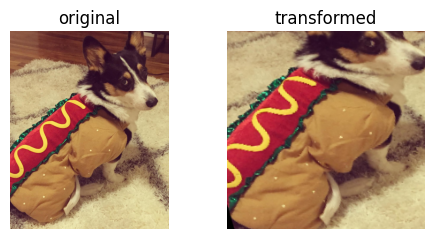

In [27]:
transforms = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1),
    A.Affine(
        scale=(0.6, 1.6),
        rotate=(-7, 15),
        translate_percent=(-0.1, 0.1),
        shear=(-10, 10),
        fill=0,
        p=1
    ),
    A.MotionBlur(
        blur_limit=(3, 10),
        angle_range=(10, 40),
        p=0.6
    )
],
    seed=42)

plot_image(
    original=img,
    transformed=transforms(image=img)["image"])

Albumentations также позволяет использовать несколько аугментаций из одной категории, случайным образом выбирая одну из них. Для этого используется конструкция A.OneOf([]), в которую передаются все необходимые из них. 

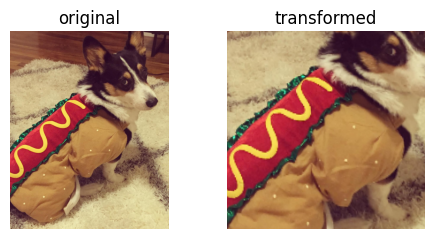

In [28]:
transforms = A.Compose([
    A.SmallestMaxSize(max_size=SIZE, p=1.0),
    A.RandomCrop(height=SIZE, width=SIZE, p=1.0),
    A.OneOf([
        A.Affine(rotate=(-15, 15), shear=(-10, 10), p=0.8),
        A.Perspective(scale=(0.05, 0.1), p=0.8)
    ], p=0.7)
], seed=42)

plot_image(img, transforms(image=img)["image"]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2811548371602697..2.188018796564667].


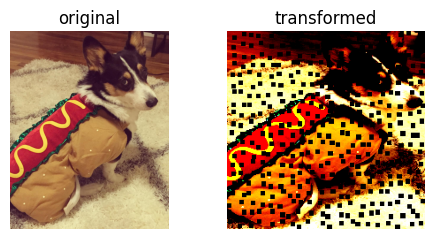

In [60]:
transforms = A.Compose([
        A.RandomResizedCrop(size=(SIZE, SIZE),
                            scale=(0.8, 0.95),
                            ratio=(0.75, 1.33),
                            p=1),
        A.OneOf([
            A.CoarseDropout(num_holes_range=(1,8),
                            hole_height_range=(int(0.1 * SIZE), int(0.2 * SIZE)),
                            hole_width_range=(int(0.1 * SIZE), int(0.2 * SIZE)),
                            fill=0,
                            p=0.4),
            A.GridDropout(ratio=0.5,
                        unit_size_range=(int(0.05 * SIZE), int(0.1 * SIZE)),
                        p=0.6)
        ], p=1),
        A.Normalize(
            normalization="image",
            p=1
        )
], seed=42)

plot_image(img, transformed=transforms(image=img)['image'])

## Учет дисбаланса классов

Аугментации позволяют не только улучшить сходимость обучения модели, но и увеличить численность слабо представленных в датасете классов. Однако это не единственный способ. Можно также модифицировать loss-функцию. Такая возможность есть в функции потерь CrossEntropyLoss — аргумент weight принимает тензор весов для каждого класса.

Например, для случая бинарной классификации с частотой класса 1, равной 0.25, взвешивание классов будет выглядеть так:

```py
import torch
import torch.nn as nn

# class_weight_N = 1 - N / total 
criterion_weighted = nn.CrossEntropyLoss(weight=torch.Tensor([0.25, 0.75])) 
```

В общем случае веса не должны быть нормализованы в диапазон от 0 до 1. Это нормально, если вы используете reduction=mean в CrossEntropyLoss, установленную по умолчанию. Но если вы этого не делаете и не усредняете элементы в батче, то нужно нормализовать вручную.

In [68]:
import torch
import torch.nn as nn

x = torch.randn(10, 5) 
print(x)
target = torch.randint(0, 5, (10,))
print(target)
weights = torch.tensor([1., 2., 3., 4., 5.]) 
print(weights)

# 1 - reduction='mean'
criterion_weighted = nn.CrossEntropyLoss(weight=weights) 
loss_weighted = criterion_weighted(x, target) 
print(loss_weighted)

# 2 - reduction='none'
criterion_weighted_manual = nn.CrossEntropyLoss(weight=weights, reduction='none') 
loss_weighted_manual = criterion_weighted_manual(x, target) 
print(loss_weighted_manual)

# нормализуем лосс на веса вручную
loss_weighted_manual = loss_weighted_manual.sum() / weights[target].sum() 
print(loss_weighted_manual)

print(loss_weighted == loss_weighted_manual) 
print(x[1, target[1]])

tensor([[-1.4837, -0.6443, -0.3233,  2.0379, -1.2672],
        [ 1.8788,  0.4222,  0.5353, -0.1497,  0.5455],
        [ 0.0441, -0.6035,  0.8734,  0.0418, -0.4611],
        [ 0.7301, -0.1890, -0.7702,  0.1321,  1.1488],
        [ 0.4737,  1.7797,  0.1024, -1.4593,  0.4414],
        [ 0.7236,  1.3723, -2.9302,  0.1210, -0.3539],
        [-1.8883,  0.9090,  0.5998, -1.0694,  0.2517],
        [-0.5363, -0.0576, -0.1641, -1.1310, -0.7599],
        [-0.0716,  0.1751,  0.0637,  0.6726,  0.5731],
        [-0.1685,  1.0338, -0.4228, -1.1071, -0.0875]])
tensor([1, 3, 2, 2, 2, 3, 2, 0, 4, 3])
tensor([1., 2., 3., 4., 5.])
tensor(2.0420)
tensor([ 5.7768, 10.6582,  2.5802,  8.4194,  6.7266,  7.7786,  3.6177,  1.6894,
         6.8076, 11.2896])
tensor(2.0420)
tensor(False)
tensor(-0.1497)


---

### 🧪 Исходные данные

```python
x = torch.randn(10, 5)        # логиты: 10 примеров, 5 классов (без softmax!)
target = torch.randint(0, 5, (10,))  # истинные метки: 10 значений от 0 до 4
weights = torch.tensor([1., 2., 3., 4., 5.])  # веса для каждого класса
```

- $x[i]$ — **логиты (raw scores)** для i-го примера.
- $target[i]$ — **индекс правильного класса** (например, `3`).
- $weights[c]$ — **насколько "важен" класс `c`**:
  - Класс `0` — вес `1` (маловажный),
  - Класс `4` — вес `5` (очень важный).

> 💡 Более высокий вес → ошибка на этом классе **сильнее влияет** на общий loss → модель будет **сильнее "стараться"** не ошибаться на нём.

---

#### 🔢 Шаг 1: `CrossEntropyLoss` с `reduction='mean'` (по умолчанию)

```python
criterion_weighted = nn.CrossEntropyLoss(weight=weights)
loss_weighted = criterion_weighted(x, target)
```

#### Что делает `CrossEntropyLoss` под капотом?

1. Для каждого примера `i`:
   - Вычисляет **логит правильного класса**: `x[i, target[i]]`
   - Применяет **log-softmax** → получает **отрицательный логарифм вероятности** (NLL):
     $$
     \text{loss}_i = -\log\left( \frac{e^{x_{i, t_i}}}{\sum_j e^{x_{i,j}}} \right)
     $$
2. Умножает каждый `loss_i` на **вес соответствующего класса**:
   $$
   \text{weighted\_loss}_i = \text{weights}[t_i] \cdot \text{loss}_i
   $$
3. Усредняет с **весами** (а не просто берёт среднее!):
   $$
   \text{loss} = \frac{\sum_i \text{weighted\_loss}_i}{\sum_i \text{weights}[t_i]}
   $$

> ✅ Это **нормализация по сумме весов истинных классов**.

---

### 🔁 Шаг 2: `reduction='none'` + ручная нормализация

```python
criterion_weighted_manual = nn.CrossEntropyLoss(weight=weights, reduction='none')
loss_weighted_manual = criterion_weighted_manual(x, target)  # это вектор [10]
```

- Теперь `loss_weighted_manual[i] = weights[target[i]] * loss_i` — **невычисленное среднее**.

Затем:

```python
loss_weighted_manual = loss_weighted_manual.sum() / weights[target].sum()
```

- `loss_weighted_manual.sum()` = $\sum_i \text{weights}[t_i] \cdot \text{loss}_i$
- `weights[target].sum()` = $\sum_i \text{weights}[t_i]$

→ Это **в точности та же формула**, что и в шаге 1!

---

### ✅ Итог

```python
print(loss_weighted == loss_weighted_manual)  # True
```

Этот код **демонстрирует**, что:

> **`nn.CrossEntropyLoss(weight=...)` с `reduction='mean'` автоматически нормализует loss по сумме весов истинных классов.**

Это **важно** для корректного масштаба loss и градиентов.

---

### 🎯 Зачем это нужно при дисбалансе?

Предположим, у вас:
- Класс `0`: 9000 примеров,
- Класс `4`: 100 примеров.

Если не использовать веса:
- Модель может "игнорировать" класс `4`, потому что его вклад в loss мал.
- Точность будет высокой (90%), но **recall для класса `4` ≈ 0**.

**Решение**: задайте веса **обратно пропорционально частоте**:

```python
# Частоты классов
freq = torch.tensor([9000, 500, 300, 150, 50], dtype=torch.float32)
weights = 1.0 / freq  # или weights = len(dataset) / (num_classes * freq)
weights = weights / weights.sum() * num_classes  # опционально: чтобы средний вес = 1
```

→ Теперь ошибка на редком классе **много сильнее влияет** на loss.

---

### 📌 Вывод

Этот код **не просто считает loss**, а **показывает, как именно веса влияют на агрегацию** — и подтверждает, что PyTorch делает это **корректно и стабильно**.

Такой подход — **один из самых простых и эффективных способов борьбы с дисбалансом классов** в классификации.

In [72]:
# Частота представленных объектов в классах
freq = np.array([800, 100, 100])
# Веса берем как долю от единицы:
weights = 1.0 / freq
# Нормализуем по стандартной формуле
normilized_weight = weights/ weights.sum()
print(weights)
print(normilized_weight) 

[0.00125 0.01    0.01   ]
[0.05882353 0.47058824 0.47058824]


# Обработка аудиоданных

## Представление и обработка аудиосигнала

Звуки, которые нас окружают, являются аналоговыми. Аналоговый звук — это непрерывная волна давления воздуха, которая может быть описана функцией s(t), где:

- t — время звучания,
    
- s(t) — амплитуда звукового давления в момент времени t.

Поскольку компьютеры не умеют обрабатывать волны давления, для компьютерной обработки аналоговый сигнал нужно преобразовать в цифровой. Этот процесс включает два основных этапа:

1. Дискретизация (sampling) — измерение амплитуды сигнала через равные промежутки времени. Фактически мы записываем только часть сигналов.
    
2. Квантование (quantization) — представление измеренной амплитуды в цифровом виде. Каждый сэмпл округляется до ближайшего значения из конечного набора разрядностей.


In [23]:
source_path: str = "ml_dl/Preprocessing_multimodals/"

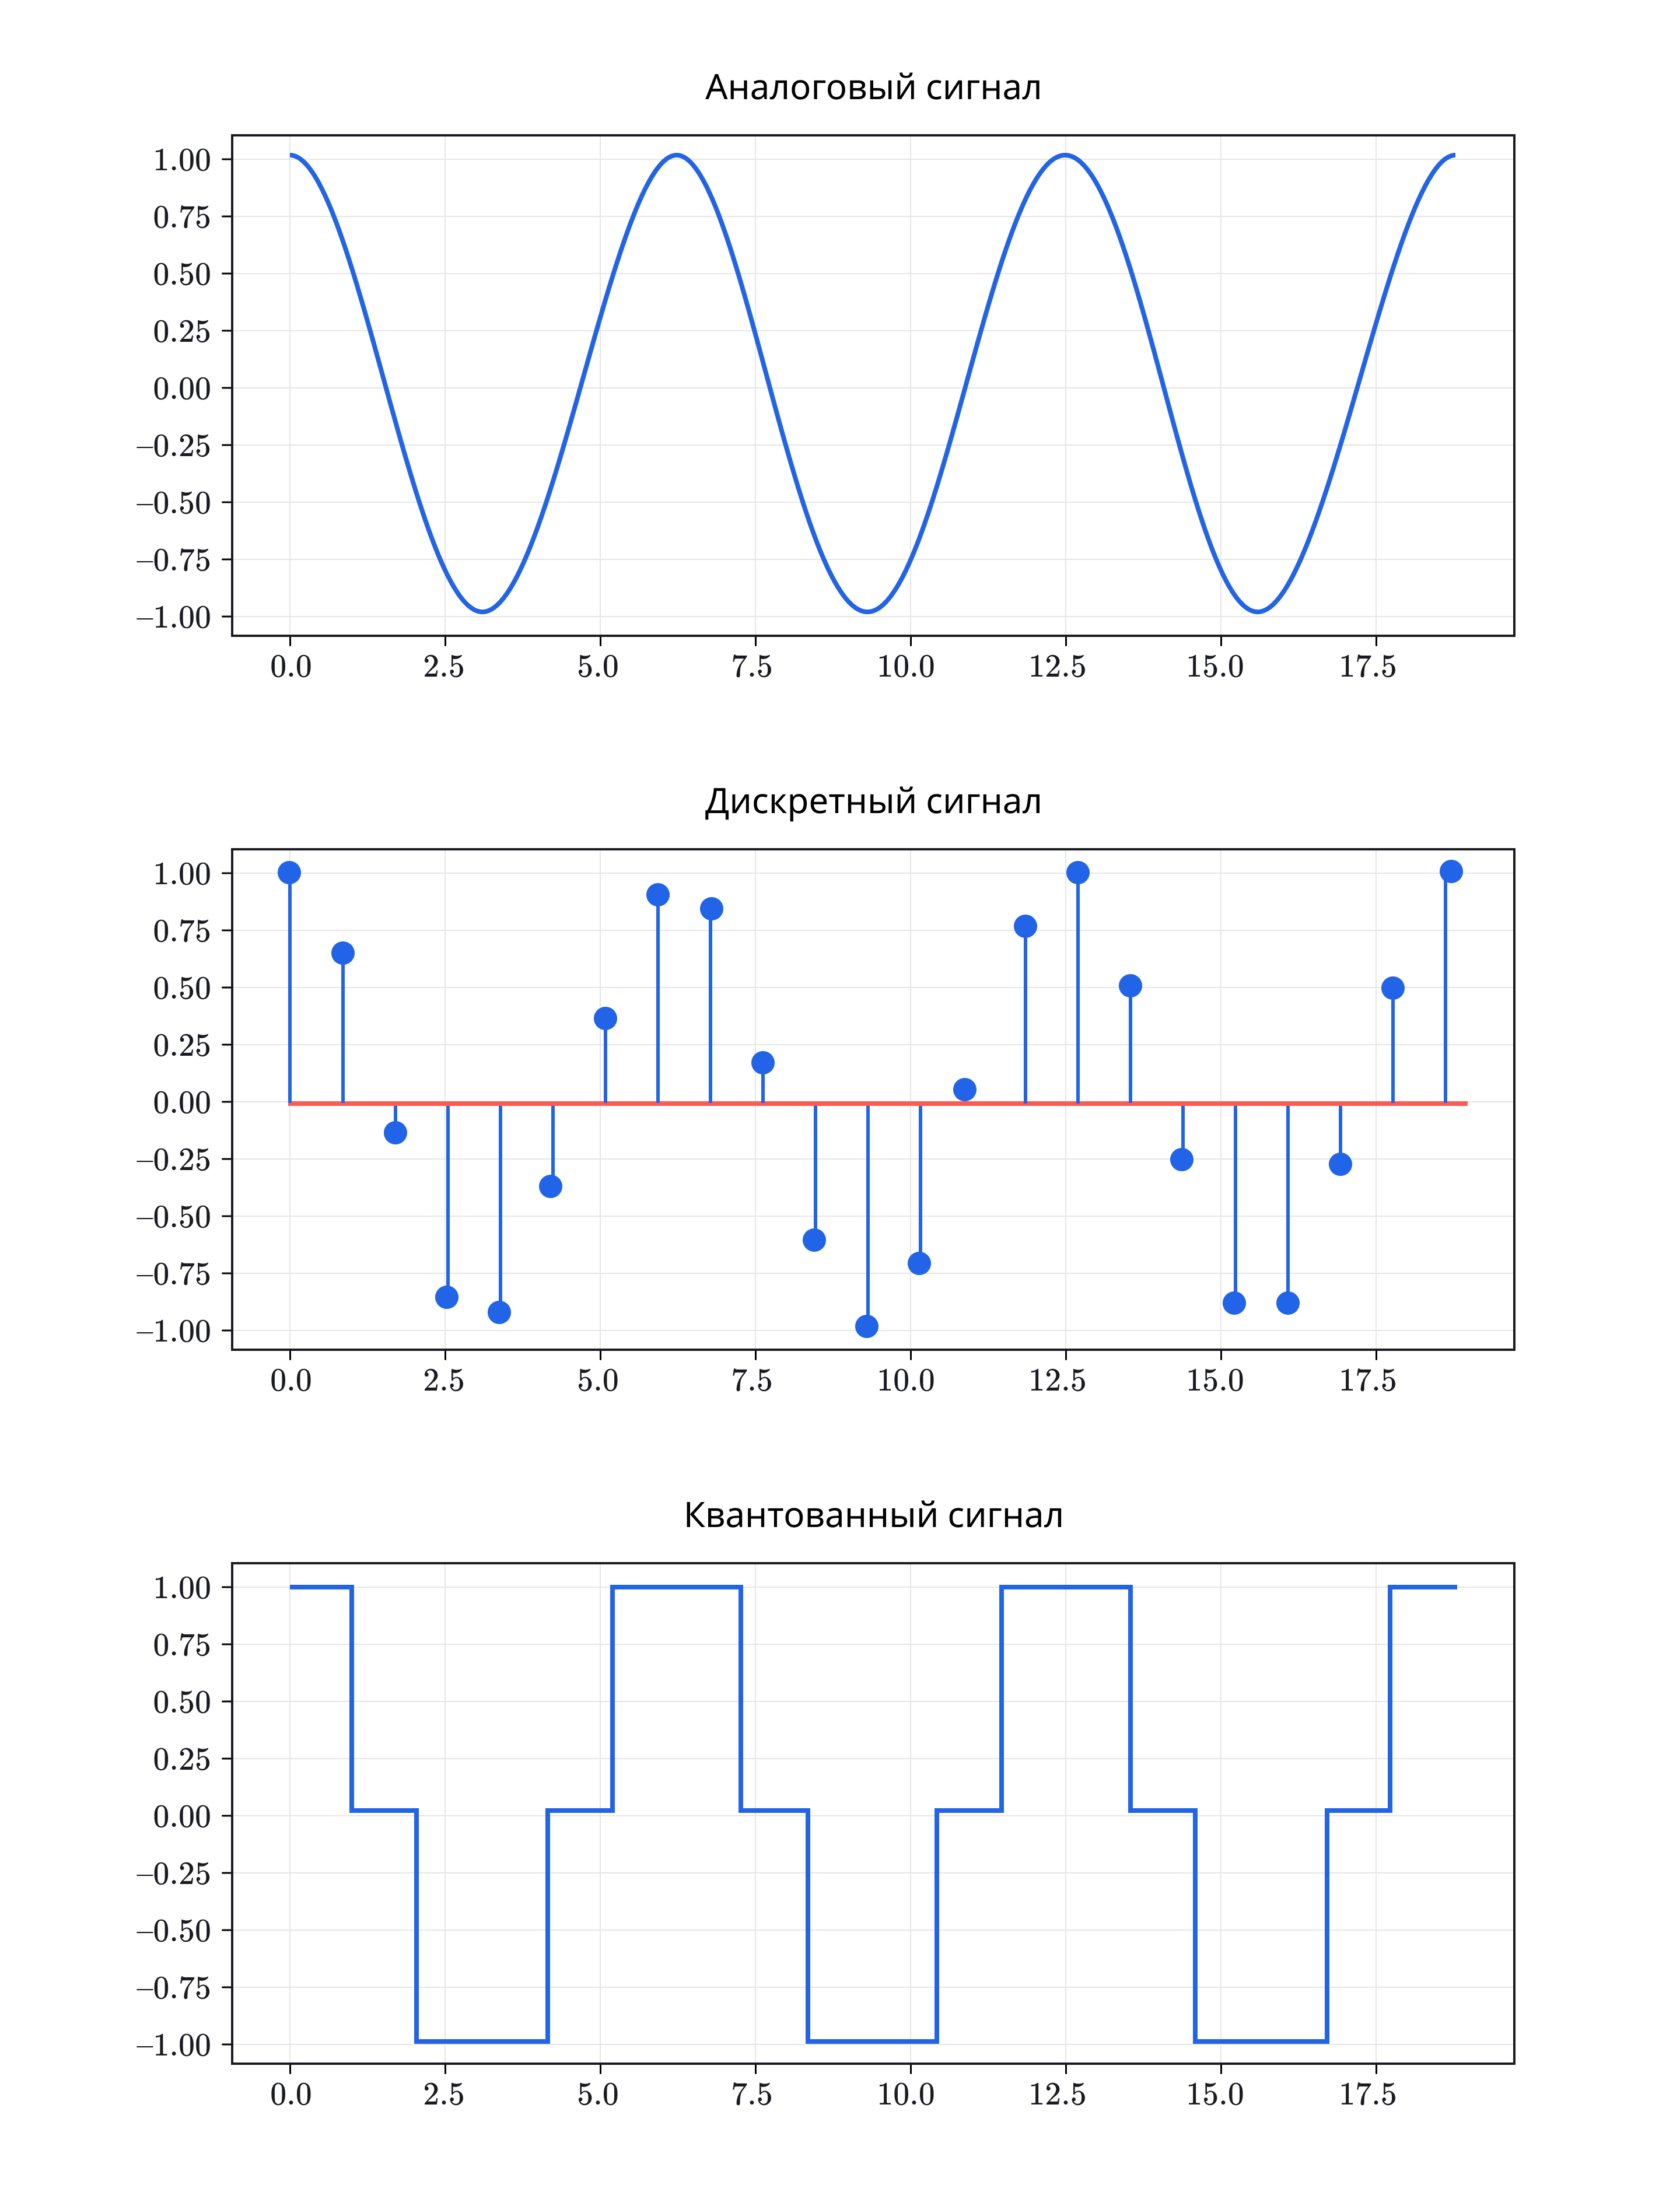

In [7]:
from ml_dl_experiments import show_image_from_source

path_to_image = source_path+ "audio.png"
show_image_from_source(path_to_image, width=600, height=800)


Каждый записанный сигнал описывается параметрами:

- Частота дискретизации (sample rate) — количество измерений (сэмплов) амплитуды в секунду (Гц). Стандартные значения:
    - 8 кГц — телефонное качество,
    - 44.1 кГц — качество аудио CD,
    - 48 кГц  — качество DVD , часто используется для аудио файлов на ПК,
    - 96 кГц и выше — аудио в высоком разрешении, профессиональная звукозапись.
- Битовая глубина (bit depth) — количество бит, используемых для хранения каждого измерения амплитуды в памяти. Обычно в диапазоне 8-32 бита.
- Количество каналов (channels) — количество аудиосигналов, которые записываются и сохраняются параллельно. Например, моно (1 канал), стерео (2 канала) и т. д.

Общий размер файла в битах определяется произведением этих параметров на длительность аудио (в секундах):
 
`sample_rate × bit_depth × channels × length_in_seconds.`

После оцифровки данные ещё раз обрабатываются при сохранении в файл. Есть много форматов сохранения данных, их можно разделить по степени сжатия:

- Без сжатия: WAV, AIFF и др.
- Сжатие с минимальными потерями (2:1): FLAC, ALAC и др.
- Сжатие с потерями (10:1): MP3, Opus и др.

Параметр, определяющий степень сжатия, — bit rate (битрэйт). Это число бит, передаваемых или обрабатываемых в единицу времени. Чем выше битрэйт, тем качественнее аудиосигнал.

Есть аудиосигнал: 5 минут, стереоформат (2х-канальный), 44.1кГц с 8 битовой глубиной. Оцените размер файла в мегабайтах. 

In [5]:
in_bits = 5 * 60 * 2 * 44100 * 8 # Сразу переводим в секунды
in_bytes = in_bits / 8
in_kbytes = in_bytes / 1024
in_mbytes = in_kbytes / 1024
print(in_mbytes)

25.234222412109375


## Преобразование аудиосигнала в спектрограммы

Работать напрямую с аудиотреком довольно сложно по двум причинам: 

- Размер файла. Чем длиннее аудио, тем сложнее держать его в памяти и делать расчёты.
    
- Сложность отделения сигнала от фонового шума. Например, когда мы работаем с распознаванием речи, важно понимать, где фоновый шум, а где речь — и по исходному аудио их довольно сложно разделить.

В задачах же для распознавания и классификации звука обрабатывают аудиосигнал как изображение.
Для этого аудио переводят в один из форматов частотно-временных спектрограмм. 

Есть много вариаций спектрограмм:

- MEL-спектрограмма,
- STFT,
- CQT,
- MFCC
- и другие.

Распространённый формат конвертации, который применяется для многих задач в обработке аудио, — Mel-спектрограмма. 

## Mel-спектрограмма

Mel — это психоакустическая шкала частот, которая отражает восприятие высоты звука человеческим ухом. Она нелинейна:

- На низких частотах (до ~1 кГц) восприятие почти линейно — звуки на этих частотах человек различает хорошо.
  
- На высоких частотах восприятие становится логарифмическим — человек различает плохо или совсем не различает.

Перейти из Гц в шкалу Mel можно так: 
$$
  Mel(f)=2595⋅lg(1+\frac{f}{700}​),
$$
где f — частота сигнала. 

Спектрограмма — это представление сигнала в виде частотно-временной визуализации, где по оси X откладывается длительность сигнала, а по оси Y — частота.

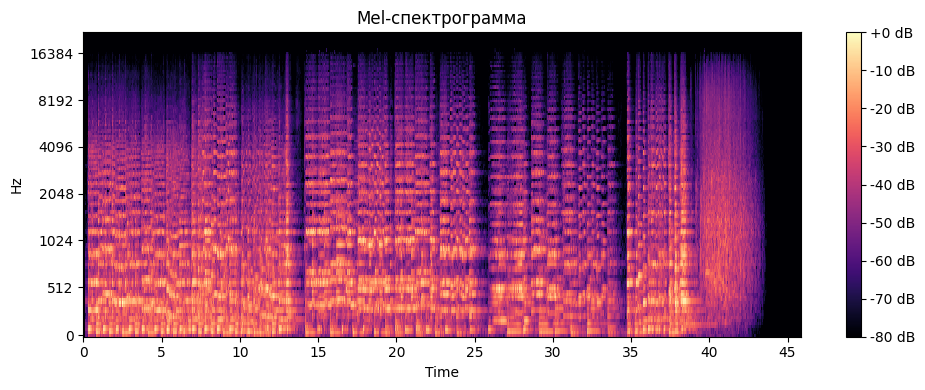

In [9]:
show_image_from_source(path=source_path+"mel.png", width=1000, height=500)

Переход от амплитуд к частотам осуществляется такой последовательностью действий:

- Сигнал разбивается на отрезки (фреймы) с перекрытием.
    
- Сигнал сглаживается, чтобы минимизировать артефакты на границах фреймов.
    
- Применяется кратковременное преобразование Фурье (STFT)  для выделения частотных компонент сигнала.
[Преобразование Фурье - операция, позволяющая разложить сигнал на составляющие, спектр, с разными частотами] 
    
- Получившийся частотный спектр переводится в энергетический и взвешивается согласно Mel-шкале: более низкие частоты получают больший вес (под каждый диапазон частот с перекрытием создаются фильтры).

- Полученный спектр переводится в децибелы (дБ).

In [11]:
import requests
import librosa
from ml_dl_experiments import settings

# загрузка аудиофайла
audio_path = settings.SOURCE_PATH + 'ml_dl/Preprocessing_multimodals/Hungarian_Dance_number_5.ogg'

url = "https://raw.githubusercontent.com/librosa/data/main/audio/Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra).hq.ogg"
response = requests.get(url, stream=True)

with open(audio_path, "wb") as f:
    f.write(response.content)

# метод возвразает загруженный сигнал и расчетный sample rate

signal, sample_rate = librosa.load(audio_path, sr=None)

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Количество сэмплов: {len(signal)}")
print(f"Длительность: {len(signal)/sample_rate:.2f} секунд") 

Частота дискретизации: 44100 Гц
Количество сэмплов: 2021760
Длительность: 45.84 секунд


Рассчитать Mel-спектрограмму поможет метод `librosa.feature.melspectrogram` из библиотеки `librosa`. Он принимает на вход несколько параметров: 

- загруженный файл,
    
- его sample rate,
    
- размер окна для Фурье-преобразования n_fft,
    
- шаг сдвига между окнами hop_length,
    
- а также число фильтров n_mels для взвешивания спектра.

Перевести Mel-спектрограмму в децибелы можно функцией `power_to_db`. В качестве референсной точки используем максимум из самого спектра. Референсная точка помогает нормализовать уровни громкости в едином масштабе и упростить визуальный анализ спектрограммы. 
Визуализируем через `librosa.display.specshow`.

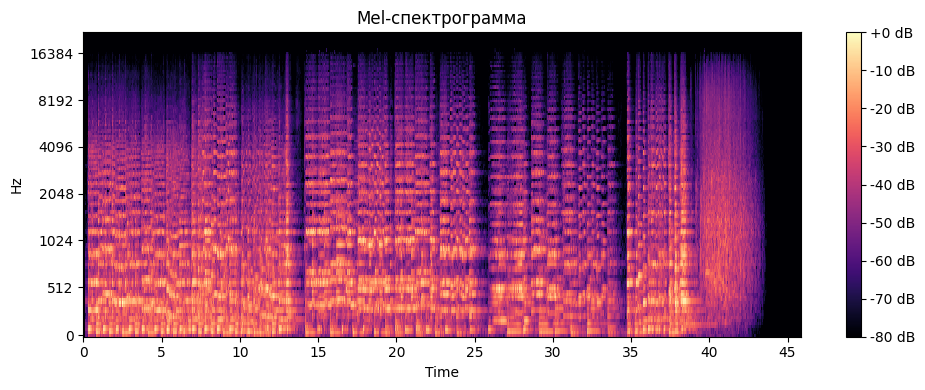

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Параметры для спектрограммы
n_fft = 2048  # размер окна для FFT

hop_length = 512  # шаг между окнами
n_mels = 128  # количество Mel-фильтров
  
# Вычисление Mel-спектрограммы
mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels)

# Преобразование в децибелы
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Визуализация
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sample_rate,
                        hop_length=hop_length,
                        x_axis='time', y_axis='mel')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма')
plt.tight_layout()
plt.show() 

Проанализируем спектрограмму:

- тёмные области соответствуют более тихим компонентам или отсутствию звука;
    
- яркие области — это значимые звуковые компоненты;
    
- очень высоких частот практически нет — часто их сразу обрезают при обработке сигнала.

### Параметры Mel-спектрограммы:

- Размер окна для Фурье-преобразования `n_fft`, число фильтров для взвешивания спектра `n_mels` — чем выше эти параметры, тем лучше точность частотного анализа, но хуже временная составляющая. Другими словами, чем выше параметры, тем чётче можно различить близкие частоты, но тем сложнее точно отследить момент, когда возник звук. `Стандарт значений: n_fft=2048, n_mels=128.`
  
- Шаг сдвига между окнами `hop_lenght` — чем он меньше, тем плавнее переход спектрограммы по времени, но больше размер данных. Можно начинать с `n_fft / 4.`

Иногда на практике целесообразно загружать не весь сигнал, а только его часть — ведь аудио может быть и 2 часа длиной. Для этого в метод `librosa.load` можно передать аргументы `offset` — сдвиг начала загрузки файла в секундах и `duration` — длительность.

Ограничьте время при загрузки с 35 по 40 секунды. Постройте Mel-спектрограмму с произвольными параметрами и визуализируйте её.

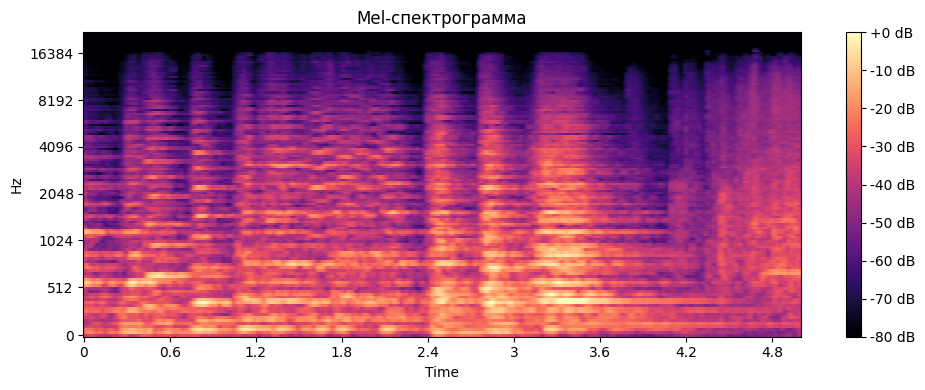

In [17]:
import matplotlib.pyplot as plt
import numpy as np

signal, sample_rate = librosa.load(
    audio_path,
    offset=35.0,
    duration=5.0,
    sr=None
)
# Параметры для спектрограммы
n_fft = 4096  # размер окна для FFT

hop_length = 256  # шаг между окнами
n_mels = 128  # количество Mel-фильтров
  
# Вычисление Mel-спектрограммы
mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels)

# Преобразование в децибелы
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Визуализация
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sample_rate,
                        hop_length=hop_length,
                        x_axis='time', y_axis='mel')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма')
plt.tight_layout()
plt.show() 

In [ ]:
# вычисление STFT (сглаживание по умолчанию)
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length,
                   win_length=n_fft)

# спектрограмма энергий
power_spec = np.abs(stft)**2

# Mel-фильтры
mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels)

# взвешивание энергетического спектра с помощью Mel-фильтров)
mel_spec = np.dot(mel_basis, power_spec)

# переход в децибелы
mel_spec_db_manual = librosa.power_to_db(mel_spec, ref=np.max)
# сравнение спектрограмм
if not np.testing.assert_array_equal(mel_spec_db, mel_spec_db_manual, verbose=True):
    print("Успех! Спектрограммы совпали.") 

Успех! Спектрограммы совпали.


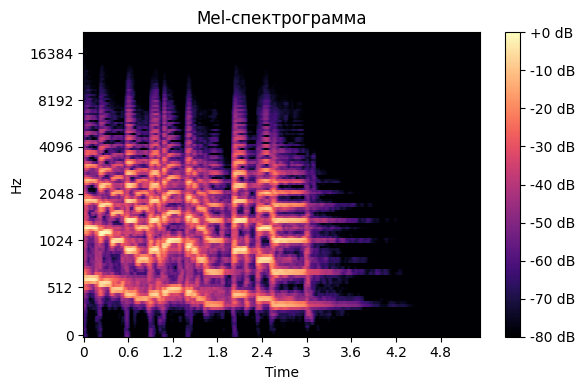

In [24]:
import requests

import librosa
import matplotlib.pyplot as plt
import numpy as np

from ml_dl_experiments import settings

audio_path: str = settings.SOURCE_PATH + source_path + "/soro.ogg"

url = "https://raw.githubusercontent.com/librosa/data/main/audio/sorohanro_-_solo-trumpet-06.hq.ogg"
response = requests.get(url, stream=True)

with open(audio_path, "wb") as f:
    f.write(response.content)

signal, sample_rate = librosa.load(
    audio_path,
    sr=None
)
n_fft = 4096  # размер окна для FFT

hop_length = 256  # шаг между окнами
n_mels = 128  # количество Mel-фильтров

mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels)

# Преобразование в децибелы
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mel_spec_db, sr=sample_rate,
            hop_length=hop_length,
            x_axis='time', y_axis='mel')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма')
plt.tight_layout()
plt.show() 

## Другие типы конвертации аудиоданных
В примерах и заданиях мы конвертировали аудиоданные в Mel-спектрограмму, но есть и другие типы конвертации. Обсудим подробнее их особенности и области применения.

- STFT — оконное преобразование Фурье, просто позволяет извлечь частотный спектр без дополнительных адаптаций как в Mel-спектрограмме, не сокращает размерность сигнала. Больше подходит для полного частотного анализа, меньше — для использования для нейросетей.
    
- CQT[deep-learning_CQT] — перевод в частотный спектр, наиболее подходящий для обработки музыки. В этой спектрограмме центры частот распределены логарифмически, отражая восприятие звука человеком.
    
- MFCC[deep-learning_MFCC] — сокращённая версия Mel-спектрограммы, используемая для обработки речи.

Посмотрим, как выглядят другие спектрограммы. STFT-спектр мы уже получали, когда поступательно вычисляли Mel-спектрограмму. Теперь давайте построим CQT-спектрограмму. Для этого используем метод librosa.cqt. Он так же принимает на вход несколько параметров: сам сигнал, sampling rate и шаг между окнами hop_length, а возвращает комплексное частотное представление сигнала, от которого мы будем брать модуль. Используем ранее загруженный аудио файл с игрой на трубе и визуализируем полученную спектрограмму.

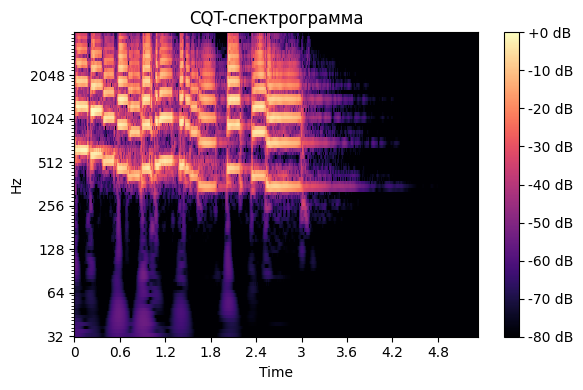

In [25]:
signal, sample_rate = librosa.load(
    path=audio_path,
    sr=None)

# вычисление cqt-спектрограммы
hop_length = 64
cqt_spec = librosa.cqt(y=signal, sr=sample_rate,
                    hop_length=hop_length)

# преобразование в децибелы
cqt_spec_db = librosa.amplitude_to_db(np.abs(cqt_spec), ref=np.max)

# визуализация
plt.figure(figsize=(6, 4))
librosa.display.specshow(cqt_spec_db, sr=sample_rate,
            hop_length=hop_length,
            x_axis='time', y_axis='cqt_hz')

plt.colorbar(format='%+2.0f dB')
plt.title('CQT-спектрограмма')
plt.tight_layout()
plt.show() 

Можно заметить, что CQT имеет ограниченный частотный спектр. В общем случае она всегда отличается от Mel-спектрограммы. 

Каждой задаче — свой наиболее подходящий формат:

- Mel — универсален, подойдёт для разных задачах.
  
- STFT полезен в точном частотном анализе.
    
- CQT подходит для музыки.

- MFCC — для распознавания речи.

# Практика. Поиск и удаление нерелевантных фотографий

Представьте, что вы занимаетесь технической поддержкой системы найма. При трудоустройстве новые сотрудники должны загрузить своё персональное фото, которое будет отображаться в личном профиле.

У компании есть требования к фото:

- на фотографии должен быть изображён только новый сотрудник;
    
- фото сделано анфас и хорошо освещено;
    
- лицо не должно быть скрыто.

Вам нужно проверить, соответствуют ли фотографии новых сотрудников требованиям компании. В качестве исходных данных вы будете использовать архив с верно выполненными фотографиями. 

Решим эту задачу, используя векторизацию картинок с помощью предобученной модели из timm: напишем свой загрузчик данных; загрузим и трансформируем картинки в формат, подходящий для модели; реализуем функцию расчёта и сравнения эмбеддингов. А в конце посмотрим на результаты решения задачи и оценим качество решения. 

In [1]:
import pathlib
from ml_dl_experiments import settings

source_dataset_path_db: str = settings.SOURCE_PATH + "datasets/faces/db"
source_dataset_path_new: str = settings.SOURCE_PATH + "datasets/faces/new"

directory = pathlib.Path(source_dataset_path_db)
db_images = []
for path in directory.iterdir():
    if path.suffix == ".PNG" or path.suffix ==".jpg" and path.is_file:
        db_images.append(path)

print(db_images)

[PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_4.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/p_10.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_3.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_8.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_6.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_2.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_7.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/p_3.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_5.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/p_5.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/ai_1.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/p_1.PNG'), PosixPath('/home/ollldman/Documents/SOURCE_PATH/datasets/faces/db/

In [2]:
import pathlib
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
import torch
import numpy as np

import torchvision.transforms.v2 as T
from torchvision.transforms import ToTensor

from ml_dl_experiments import settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FaceDataset(Dataset):
    def __init__(self,
                 dataset_root: str,
                 transforms):
        super(FaceDataset, self).__init__()
        self.data_directory = pathlib.Path(dataset_root)
        self.transforms = transforms
        self.db_images = []

        for path in self.data_directory.iterdir():
            if path.suffix.lower() == ".png" \
                or path.suffix.lower() ==".jpg"\
                      and path.is_file:
                self.db_images.append(path)

    def __len__(self):
        return len(self.db_images)
    
    def __getitem__(self, idx):
        image_path = self.db_images[idx]
        image = Image.open(image_path).convert("RGB")
        transformed_image = self.transforms(image)
        return transformed_image, str(image_path)

In [4]:
model_name = 'tf_efficientnet_b0'
cfg = timm.get_pretrained_cfg(model_name)
cfg

PretrainedCfg(url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth', file=None, state_dict=None, hf_hub_id='timm/tf_efficientnet_b0.ns_jft_in1k', hf_hub_filename=None, source=None, architecture='tf_efficientnet_b0', tag='ns_jft_in1k', custom_load=False, input_size=(3, 224, 224), test_input_size=None, min_input_size=None, fixed_input_size=False, interpolation='bicubic', crop_pct=0.875, test_crop_pct=None, crop_mode='center', mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), num_classes=1000, label_offset=None, label_names=None, label_descriptions=None, pool_size=(7, 7), test_pool_size=None, first_conv='conv_stem', classifier='classifier', license='apache-2.0', description=None, origin_url=None, paper_name=None, paper_ids=None, notes=None)

In [5]:
SIZE: tuple[int, int] = cfg.input_size[1:] # type: ignore
mean: tuple[float, float, float] = cfg.mean # type: ignore
std: tuple[float, float, float] = cfg.std # type: ignore 
BATCH_SIZE: int = 2

In [6]:
transform = T.Compose([
    T.Resize(
        size = SIZE),
    T.RandomVerticalFlip(p=0.5),
    ToTensor(),
    T.Normalize(mean, std)
])

source_dataset_path_db: str = settings.SOURCE_PATH + "datasets/faces/db"
source_dataset_path_new: str = settings.SOURCE_PATH + "datasets/faces/new"

# Создаём DataLoader для проверенных и новых изображений
db_dataset = FaceDataset(
    dataset_root=source_dataset_path_db, 
    transforms=transform)
new_dataset = FaceDataset(
    dataset_root=source_dataset_path_new,
    transforms=transform
)

db_loader = DataLoader(db_dataset, batch_size=BATCH_SIZE, num_workers=2)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, num_workers=2)

Загрузим модель, посмотрим, что она вернет по 1 фото

In [31]:
from transformers import TrainingArguments
from torchsummary import summary

x = torch.randn(1, 3, 224, 224)
model = timm.create_model(
    model_name=model_name,
    pretrained=False,
    features_only=True
)
model

EfficientNetFeatures(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): B

In [33]:
summary(model, (3, 224, 224), batch_size=2, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1          [2, 32, 112, 112]             864
          Identity-2          [2, 32, 112, 112]               0
              SiLU-3          [2, 32, 112, 112]               0
    BatchNormAct2d-4          [2, 32, 112, 112]              64
            Conv2d-5          [2, 32, 112, 112]             288
          Identity-6          [2, 32, 112, 112]               0
              SiLU-7          [2, 32, 112, 112]               0
    BatchNormAct2d-8          [2, 32, 112, 112]              64
          Identity-9          [2, 32, 112, 112]               0
           Conv2d-10               [2, 8, 1, 1]             264
             SiLU-11               [2, 8, 1, 1]               0
           Conv2d-12              [2, 32, 1, 1]             288
          Sigmoid-13              [2, 32, 1, 1]               0
    SqueezeExcite-14          [2, 32, 1

In [35]:
features = model(x)

print([x.size() for x in features], sep='\n')

[torch.Size([1, 16, 112, 112]), torch.Size([1, 24, 56, 56]), torch.Size([1, 40, 28, 28]), torch.Size([1, 112, 14, 14]), torch.Size([1, 320, 7, 7])]


Модель возвращает 5 признаков

In [ ]:
print(features[0]) # первый возвращаемый признак модели

tensor([[[[-0.2264,  1.1095, -0.7099,  ..., -1.1037,  1.0381, -0.1308],
          [ 0.6098, -1.0293, -0.3893,  ...,  0.2696, -2.6099, -1.5359],
          [ 0.4648,  1.1461, -0.5091,  ...,  0.5707,  0.4857, -0.5404],
          ...,
          [ 0.3068,  1.6755,  0.6363,  ..., -1.2780,  1.5392,  0.6886],
          [-0.4129, -1.1444, -0.8529,  ...,  1.6122,  0.3205, -0.0198],
          [-0.3470,  0.2531,  0.8283,  ...,  2.0283, -0.0879,  0.3474]],

         [[-0.0859,  0.8803,  0.7851,  ...,  0.4683,  0.0161,  0.6054],
          [-0.8582, -1.7274, -0.9529,  ...,  0.1081,  1.2099,  0.8291],
          [-1.2620, -0.5442,  0.1731,  ...,  0.0176, -1.7387,  0.5499],
          ...,
          [ 0.1318, -0.1391,  0.0327,  ...,  0.0048, -0.4398, -0.2193],
          [ 0.1853,  1.0386, -0.1616,  ..., -0.0198, -1.1626, -0.0560],
          [ 0.0517,  0.5885,  0.1801,  ...,  0.6783,  0.0431,  0.9586]],

         [[-0.8700,  0.4561,  1.0594,  ..., -0.0557,  0.5365, -0.1579],
          [ 0.4986,  0.9320,  

У нас стоит задача построить функцию, которая должна вернуть конкатенированные 2 последних признака модели с использованием avg_pool2d для агрегации значений. Потом рассчитать таким образом эмбеддинги всех фото и визуализировать размерность новых фото.

In [ ]:
a = F.avg_pool2d(features[0], (features[0].size(-2), features[0].size(-1))) 
print(a, a.shape)

tensor([[[[-1.2972e-08]],

         [[-1.8855e-08]],

         [[ 1.0054e-08]],

         [[-7.6169e-09]],

         [[-1.2577e-08]],

         [[-3.0506e-09]],

         [[-1.0741e-08]],

         [[-4.2931e-09]],

         [[-2.4946e-09]],

         [[-2.9253e-08]],

         [[-4.2385e-09]],

         [[-1.3970e-09]],

         [[-8.0683e-09]],

         [[ 1.5356e-08]],

         [[-1.5172e-08]],

         [[-2.5326e-09]]]], grad_fn=<AvgPool2DBackward0>) torch.Size([1, 16, 1, 1])


Вы передаёте (x.size(-2), x.size(-1)) как kernel_size, чтобы динамически применить глобальное усреднение по всей пространственной области каждого feature map, независимо от его текущего размера. Это стандартный приём для получения глобального дескриптора каждого канала.

🔍 Что делает F.avg_pool2d(x, (H, W))?

Когда вы задаёте kernel_size=(H, W), вы говорите:

>«Возьми всё пространство (всю высоту и всю ширину) каждого feature map и усредни его в одно число».

Это называется Global Average Pooling (GAP).

Результат:

`Вход: (B, C, H, W)`
`Выход: (B, C, 1, 1)`

→ Каждый канал (признак) сжимается в одно скалярное значение, представляющее усреднённую активацию по всей карте признаков.

In [7]:
import torch.nn.functional as F

def get_embeddings(loader, model, device):
    model.to(device)
    embeddings = []
    paths = []
    with torch.no_grad():
        for images, image_paths in loader:
            images = images.to(device)
            features = model(images)
            # Конкатенируем 
            features = torch.cat(
                [F.avg_pool2d(x, (x.size(-2), x.size(-1)))
                  for x in features], 
                  dim=1).squeeze((-1, -2))

            embeddings.append(features.cpu())
            paths.extend(image_paths)
            images = images.to("cpu")
    model.to("cpu")
    return torch.cat(embeddings, dim=0), paths

Давайте разберём по шагам, что делает этот код на простом примере:

```py
features = torch.cat(
                [F.avg_pool2d(x, (x.size(-2), x.size(-1)))
                  for x in features], 
                  dim=1).squeeze((-1, -2))
```

---

### 🎯 Цель кода

Этот фрагмент обычно используется в **feature pyramid networks** или **multi-scale feature aggregation**, чтобы:

1. **Усреднить каждый feature map по пространственным измерениям (высота × ширина)** → получаем **глобальное усреднение (Global Average Pooling)** для каждого feature map.
2. **Объединить результаты по глубине (каналам)** через `torch.cat(..., dim=1)`.
3. **Убрать "лишние" размерности высоты и ширины** (ставшие 1 после усреднения) с помощью `squeeze((-1, -2))`.

---

### 🧮 Пример с конкретными тензорами

Предположим, у нас есть список `features` из **двух feature maps**:

```python
features = [
    torch.tensor([[[[1., 2.],
                    [3., 4.]]]]),      # shape: (1, 1, 2, 2)
    torch.tensor([[[[5., 6.],
                    [7., 8.]],
                   [[9., 10.],
                    [11., 12.]]]])   # shape: (1, 2, 2, 2)
]
```

> Объяснение форм:
> - Первый тензор: `batch=1`, `channels=1`, `H=2`, `W=2`
> - Второй тензор: `batch=1`, `channels=2`, `H=2`, `W=2`

---

### Шаг 1: `F.avg_pool2d(x, (x.size(-2), x.size(-1)))`

Это делает **глобальное усреднение по высоте и ширине** → выход будет `(B, C, 1, 1)`.

#### Для первого тензора:
```python
x1 = features[0]  # shape (1, 1, 2, 2)
pooled1 = F.avg_pool2d(x1, (2, 2))  # усредняем всё пространство
# Среднее: (1 + 2 + 3 + 4) / 4 = 2.5
# Результат: tensor([[[[2.5]]]])  → shape (1, 1, 1, 1)
```

#### Для второго тензора:
```python
x2 = features[1]  # shape (1, 2, 2, 2)
pooled2 = F.avg_pool2d(x2, (2, 2))
# Канал 0: (5+6+7+8)/4 = 6.5
# Канал 1: (9+10+11+12)/4 = 10.5
# Результат: tensor([[[[ 6.5]], [[10.5]]]]) → shape (1, 2, 1, 1)
```

---

### Шаг 2: `torch.cat([...], dim=1)`

Объединяем по **оси каналов (`dim=1`)**:

```python
cat_result = torch.cat([pooled1, pooled2], dim=1)
# pooled1: (1, 1, 1, 1)
# pooled2: (1, 2, 1, 1)
# Результат: (1, 3, 1, 1)

# Значения: tensor([[[[2.5]], [[6.5]], [[10.5]]]])
```

---

### Шаг 3: `.squeeze((-1, -2))`

Удаляем **последние две размерности** (ширина и высота, обе = 1):

```python
final = cat_result.squeeze((-1, -2))
# Было: (1, 3, 1, 1)
# Стало: (1, 3)

# Значения: tensor([[2.5, 6.5, 10.5]])
```

---

### ✅ Итог

Исходные feature maps:
- `(1, 1, 2, 2)` → усреднённый канал: `2.5`
- `(1, 2, 2, 2)` → усреднённые каналы: `6.5`, `10.5`

После всей операции:
- Получаем **вектор признаков**: `(1, 3)` — по одному числу на каждый исходный канал.

> 💡 Это типичный способ **агрегировать пространственную информацию** в один вектор, сохраняя семантику каждого канала.

---

### 📌 Когда это используется?

- В классификации: замена `AdaptiveAvgPool2d((1,1))` при multi-head feature extraction.
- В детекторах (например, FPN): объединение признаков разных уровней.
- В attention-механизмах: получение "глобального дескриптора" из каждого feature map.

Теперь загрузим модель в режиме FE - feature extraction. Получим и сохраним эмбеддинги и пути через numpy

In [8]:
model = timm.create_model(
    model_name=model_name,
    pretrained=True,
    features_only=True,
    out_indices=[3,4] # последний и предпоследний признаки
)
model.eval()

# Получаем эмбеддинги для проверенных и новых изображений
db_embeddings, db_paths = get_embeddings(db_loader, model, device)
new_embeddings, new_paths = get_embeddings(new_loader, model, device)

# Опционально сохраним для переиспользования
torch.save(db_embeddings, f=source_dataset_path_db+"/db_embeddings.pt")
torch.save(new_embeddings, f=source_dataset_path_new+ "/new_embeddings.pt")

file_path = source_dataset_path_new+"/new_paths"
np.save(file_path, np.array(new_paths))

print(new_embeddings.shape) 

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


torch.Size([9, 432])


✅ 1. Предупреждение о "Unexpected keys" — это нормально

```text
 Unexpected keys (bn2.bias, ..., classifier.weight, ...) found while loading pretrained weights.
```
Это не ошибка, а предупреждение, и оно ожидаемо, потому что:

- Вы создаёте модель с параметром features_only=True:

```py
timm.create_model(..., features_only=True, out_indices=[3,4])
```

- В этом режиме классификатор (classifier) и голова (conv_head) удаляются из модели (они не нужны для извлечения признаков).
    
- Но предобученные веса всё равно содержат параметры этих слоёв.
    
- PyTorch загружает только совпадающие параметры, а остальные игнорирует с предупреждением.

👉 Вывод: ничего страшного — модель загружена правильно, и предобученные признаки используются.

Теперь приступим к поиску невалидных фотографий.

Напишем функцию `find_invalid_images`, вычисляющую косинусную близость двух матриц эмбеддингов. Функция: 

- Принимает на вход 2 тензора эмбеддингов, пути до новых фото и порог косинусной близости для отнесения к «неправильным» фото.
  
- Выполняет их нормализацию.
    
- Возвращает результаты расчёта близости для каждого из новых изображений. В дополнение к косинусной близости, возвращаются пути до новых фото, отнесённых к «неправильным».

Визуально оценим качество разделения — по требованиям к фото от компании. Поэкспериментируйте с порогом для разделения, чтобы найти все фото, не подходящие под требования.

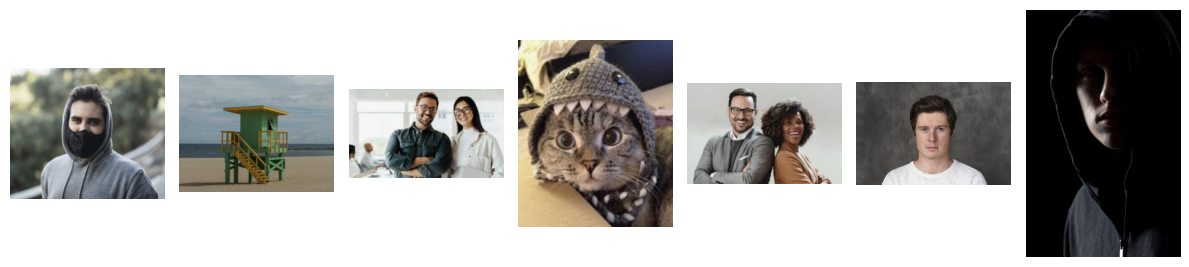

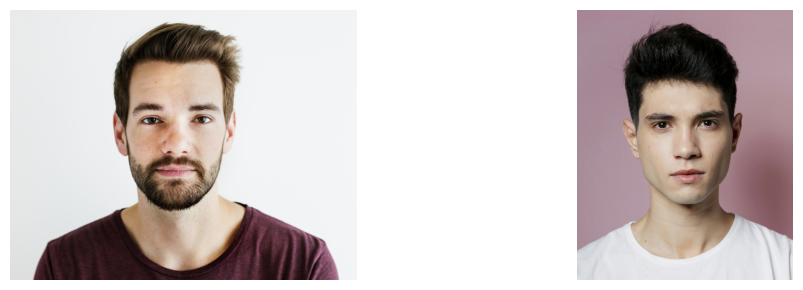

In [10]:
import torch
import torch.nn.functional as F
import numpy as np 

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


db_embeddings = torch.load(source_dataset_path_db+"/db_embeddings.pt")
new_embeddings = torch.load(source_dataset_path_new+"/new_embeddings.pt")

file_path = source_dataset_path_new+"/new_paths.npy"
new_paths = np.load(file_path)


def display_images(image_paths, figsize=(12, 3)):
    """
    Отображает изображения из списка путей в одну строку (горизонтально)
    """
    num_images = len(image_paths)

    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    fig.subplots_adjust(wspace=0.2)

    # Отображаем изображения
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def find_invalid_images(new_embeddings, db_embeddings, new_paths, threshold=0.5):
    # Нормализуем эмбеддинги
    db_embeddings = F.normalize(db_embeddings, p=2, dim=1)
    new_embeddings = F.normalize(new_embeddings, p=2, dim=1)
    
    similarities = cosine_similarity(new_embeddings.numpy(),
                                     db_embeddings.numpy())
    max_similarities = similarities.max(axis=1)

    invalid_mask = max_similarities < threshold 
    invalid_paths = new_paths[invalid_mask]

    return invalid_paths, max_similarities



invalid_images, similarities = find_invalid_images(new_embeddings, 
             db_embeddings, new_paths, threshold=0.7)

# Визуализируем фото, не прошедшие проверку
display_images(invalid_images)
# Визуализируем фото, прошедшие проверку
display_images(list(set(new_paths).difference(invalid_images))) 